### Lab 2: HR Diagram of NGC 6819

<!-- Below are the steps to reduce data:
1. Stack bias frames to compute median frame
2. Subtract bias frame from dark frame and stack to compute median frame
3. $\rm~Flat_{\rm~{dome}} = \frac{flat_{\rm~}}{}$ -->

In [83]:
import os 
from astropy.io import fits
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.background import LocalBackground, MedianBackground
from photutils.detection import DAOStarFinder
from astropy.stats import sigma_clipped_stats
from astropy.wcs import WCS

import astroalign
%matplotlib widget

#### 1. Data Reduction

In [2]:
# Directory where data is stored
_cache_dir =  "c:\\Users\\avipa\\OneDrive\\Documents\\Coursework\\_cache\\HR_Diagram"

In [3]:
# Load Data 
hdu_lst = np.array([])
for f in os.listdir(_cache_dir):
    hdu_lst = np.append(hdu_lst, fits.open(os.path.join(_cache_dir,f)))

In [4]:
# Keys to sort fits files 
obj_lst = np.array([0]*len(hdu_lst), dtype='object')
for i in range(len(hdu_lst)):
    obj_lst[i] = hdu_lst[i].header['OBJECT']

print('filenames', np.unique(obj_lst))

filenames ['bias AR' 'darks 10 AR' 'dome flats 10 B AR' 'dome flats 10 V AR'
 'landolt B AR 25s' 'landolt V AR 30s' 'ngc 6819 B AR 25s'
 'ngc 6819 v AR 30s']


In [5]:
# Sort frames by label
bias_frames = hdu_lst[np.where(obj_lst=='bias AR')]
dark_frames = hdu_lst[np.where(obj_lst=='darks 10 AR')]

dome_flats_B_frames = hdu_lst[np.where(obj_lst=='dome flats 10 B AR')]
dome_flats_V_frames = hdu_lst[np.where(obj_lst=='dome flats 10 V AR')]

landolt_B_frames = hdu_lst[np.where(obj_lst=='landolt B AR 25s')]
landolt_V_frames = hdu_lst[np.where(obj_lst=='landolt V AR 30s')]

ngc6819_B_frames = hdu_lst[np.where(obj_lst=='ngc 6819 B AR 25s')]
ngc6819_V_frames = hdu_lst[np.where(obj_lst=='ngc 6819 v AR 30s')]

In [6]:
WCS(ngc6819_B_frames[0].header), WCS(ngc6819_V_frames[0].header)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-END to 60577.199528 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60577.195974 from DATE-END'. [astropy.wcs.wcs]


(WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN'  'DEC--TAN'  
 CRVAL : 295.3270568848  40.1900062561  
 CRPIX : 512.0  512.0  
 CD1_1 CD1_2  : -0.0001027239995892  -3.946270226152e-06  
 CD2_1 CD2_2  : 3.946270226152e-06  -0.0001027239995892  
 NAXIS : 1056  1024,
 WCS Keywords
 
 Number of WCS axes: 2
 CTYPE : 'RA---TAN'  'DEC--TAN'  
 CRVAL : 295.3270568848  40.1900062561  
 CRPIX : 512.0  512.0  
 CD1_1 CD1_2  : -0.0001027239995892  -3.946270226152e-06  
 CD2_1 CD2_2  : 3.946270226152e-06  -0.0001027239995892  
 NAXIS : 1056  1024)

In [7]:
def reduce_data(bias, dark, dome_flat, science):
    """ Performs all data reduction steps and returns reduced science frame
    """

    # Median Bias Frames
    bias_full = np.median(np.stack([b.data for b in bias]),axis=0)
    print(np.median(bias_full))
    # Median Dark Frames 
    dark_exptime = dark[0].header['EXPTIME']
    dark_full = np.median(np.stack([(b.data - bias_full) for b in dark]),axis=0)

    # Median Dome Flats
    df_exptime = dome_flat[0].header['EXPTIME']
    dome_flat_full = np.median(np.stack([( (b.data/df_exptime) \
                                        - (dark_full/dark_exptime) )/np.median(b.data) for b in dome_flat]), axis=0)

    # Median Science Frames
    sci_exptime = science[0].header['EXPTIME']
    sci_full = np.median(np.stack([((b.data/sci_exptime) - (dark_full/dark_exptime))/dome_flat_full for b in science]), axis=0)

    print(f"Exposure Times:\nDome Flat - {df_exptime}s\nDark - {dark_exptime}s\nScience - {sci_exptime}s\n")
    return sci_full
    

In [8]:
# Reduce science frames
red_sci_ngc6819_B = reduce_data(bias_frames, dark_frames, dome_flats_B_frames, ngc6819_B_frames)
red_sci_ngc6819_V = reduce_data(bias_frames, dark_frames, dome_flats_V_frames, ngc6819_V_frames)

red_sci_landolt_B = reduce_data(bias_frames, dark_frames, dome_flats_B_frames, landolt_B_frames)
red_sci_landolt_V = reduce_data(bias_frames, dark_frames, dome_flats_V_frames, landolt_V_frames)

sci_red = {'ngc6819_B':red_sci_ngc6819_B,'ngc6819_V':red_sci_ngc6819_V, 'landolt_B':red_sci_landolt_B, 
                'landolt_V':red_sci_landolt_V}


1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 25s

1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 30s

1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 25s

1095.0
Exposure Times:
Dome Flat - 10s
Dark - 10s
Science - 30s



In [9]:
np.std(red_sci_ngc6819_B), np.std(red_sci_landolt_B), np.std(red_sci_landolt_V)

(45.368176279897, 37.65939384996063, 168.56143311013426)

In [330]:
fits.writeto(os.path.join(_cache_dir, "ngc6819_B.fits"), sci_red['ngc6819_B'])
fits.writeto(os.path.join(_cache_dir,"ngc6819_V.fits" ), sci_red['ngc6819_V'])

In [102]:
# Bad-pixel mask over science images of NGC 6819 
red_sci_ngc6819_B_v2 = red_sci_ngc6819_B.copy()
red_sci_ngc6819_B_v2[0,:] = np.nan
red_sci_ngc6819_B_v2[0:30,0:30] = np.nan
red_sci_ngc6819_B_v2[:,256] = np.nan
red_sci_ngc6819_B_v2[:,783] = np.nan
red_sci_ngc6819_B_v2[:,1021:] = np.nan
red_sci_ngc6819_B_v2[:,1002] = np.nan
red_sci_ngc6819_B_v2[960:,0:60] = np.nan

red_sci_ngc6819_V_v2 = red_sci_ngc6819_V.copy()
red_sci_ngc6819_V_v2[0,:] = np.nan
red_sci_ngc6819_V_v2[0:30,0:30] = np.nan
red_sci_ngc6819_V_v2[:,256] = np.nan
red_sci_ngc6819_V_v2[:,783] = np.nan
red_sci_ngc6819_V_v2[:,1021:] = np.nan
red_sci_ngc6819_V_v2[:,1002] = np.nan
red_sci_ngc6819_V_v2[960:,0:60] = np.nan

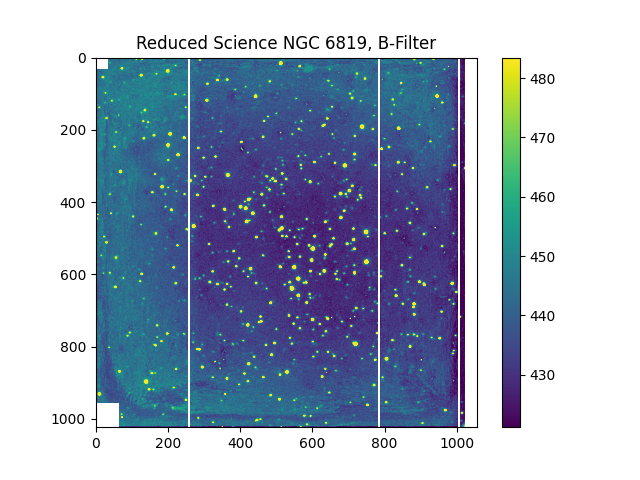

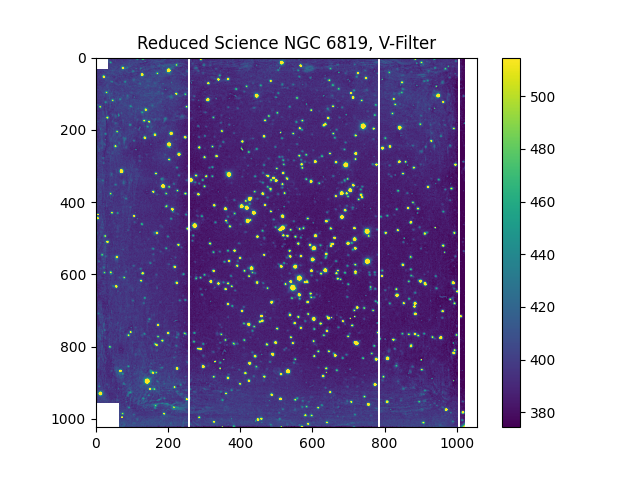

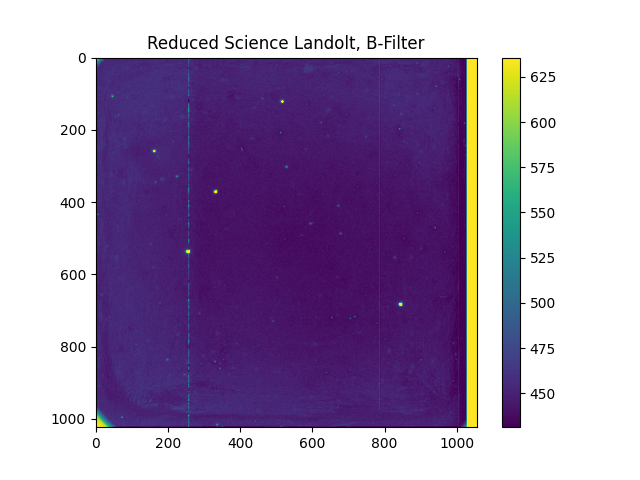

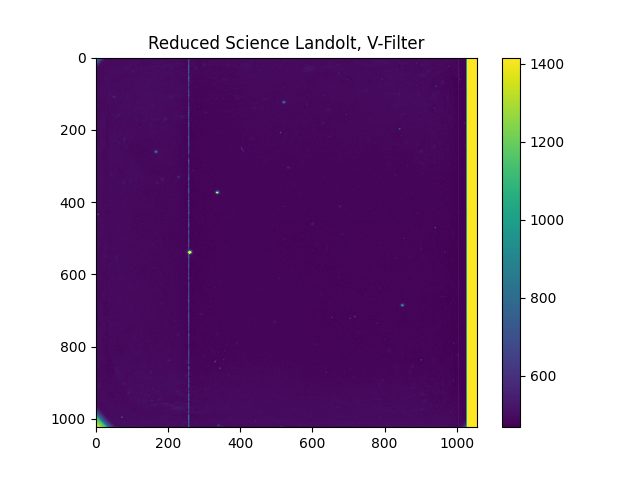

In [104]:
plt.figure()
plt.title("Reduced Science NGC 6819, B-Filter")
plt.imshow(red_sci_ngc6819_B_v2, vmin=np.nanpercentile(red_sci_ngc6819_B_v2, 3), vmax=np.nanpercentile(red_sci_ngc6819_B_v2, 99))
plt.colorbar()

plt.figure()
plt.title("Reduced Science NGC 6819, V-Filter")
plt.imshow(red_sci_ngc6819_V_v2, vmin=np.nanpercentile(red_sci_ngc6819_V_v2, 3), vmax=np.nanpercentile(red_sci_ngc6819_V_v2, 99))
plt.colorbar()

plt.figure()
plt.title("Reduced Science Landolt, B-Filter")
plt.imshow(red_sci_landolt_B, vmin=np.percentile(red_sci_landolt_B, 3), vmax=np.percentile(red_sci_landolt_B, 97))
plt.colorbar()

plt.figure()
plt.title("Reduced Science Landolt, V-Filter")
plt.imshow(red_sci_landolt_V, vmin=np.percentile(red_sci_landolt_V, 3), vmax=np.percentile(red_sci_landolt_V, 97))
plt.colorbar()

#### 2. Aperture Photometry using  `Photutils`

Landolt Field Stars: [https://www.wiyn.org/Observe/Landolt/recommendedfields.html](https://www.wiyn.org/Observe/Landolt/recommendedfields.html)

In [105]:
def find_stars(sci, fwhm= 5, std_level=3):
    """ Uses DAOStarFinder to locate stars in science frame
    """
    mean, median, std = sigma_clipped_stats(sci, sigma=5.0)   
    print(f"mean:{mean}, median:{median}, std:{std}") 
    daofind = DAOStarFinder(fwhm=fwhm, threshold=std_level*std, exclude_border=True)  
    sources = daofind(sci - median)
    
    return sources.to_pandas()

We find the Landalt Stars, 

In [58]:
# We trim the borders of each science frame to remove bad pixels at the edges
res_land_B = sci_red['landolt_B'][100:900, 250:900]
res_land_V = sci_red['landolt_V'][100:900, 250:900]

sources_landalt_B = find_stars(res_land_B)
sources_landalt_V = find_stars(res_land_V)

mean:443.66654975153216, median:443.4474299065421, std:6.793811178842453
mean:483.75829112733123, median:483.54016640895367, std:8.108127222411136


In [59]:
sources_landalt_B.sort_values(['flux'], axis=0, ascending=False, inplace=True)
positions_land_B = sources_landalt_B.filter(['xcentroid', 'ycentroid'])

sources_landalt_V.sort_values(['flux'], axis=0, ascending=False, inplace=True)
positions_land_V = sources_landalt_V.filter(['xcentroid', 'ycentroid'])

In [60]:
sources_landalt_B

id   xcentroid   ycentroid  sharpness  roundness1  roundness2  npix  \
83    84    3.814237  438.239497   0.478138   -0.120777   -0.009612    49   
101  102  592.042525  584.323838   0.365281   -0.351016   -0.287153    49   
50    51   80.689227  272.671765   0.436923   -0.171946   -0.250318    49   
5      6  264.740072   22.859704   0.431653   -0.228596   -0.277643    49   
25    26  588.874180   98.263628   0.595236   -0.222143   -0.148718    49   
..   ...         ...         ...        ...         ...         ...   ...   
114  115  137.048938  622.380317   0.396436    0.268799    0.008738    49   
88    89  461.339484  469.652741   0.860891    0.109711    0.221525    49   
70    71  239.806143  367.190333   0.787609   -0.130663   -0.030671    49   
134  135  550.224877  760.438449   0.484794    0.502299    0.687446    49   
78    79  622.842878  416.334872   0.659077   -0.231359   -0.710009    49   

     sky         peak        flux       mag  
83   0.0  1842.539444  129.401716 -5.279850  
101  0.0  1243.750932   89.764887 -4.882766  
50   0.0   945.573660   64.374704 -4.521788  
5    0.0   528.332582   36.304534 -3.899902  
25   0.0   173.495427   14.188694 -2.879856  
..   ...          ...         ...       ...  
114  0.0     5.247656    1.005842 -0.006325  
88   0.0    11.523897    1.005490 -0.005944  
70   0.0     8.653225    1.004833 -0.005235  
134  0.0    12.066179    1.003882 -0.004207  
78   0.0     7.011748    1.001402 -0.001521  

[148 rows x 11 columns]

In [61]:
sources_landalt_V

id   xcentroid   ycentroid  sharpness  roundness1  roundness2  npix  \
152  153    8.323399  440.171207   0.601288    0.237626    0.069426    49   
102  103   84.575924  274.590947   0.625385    0.109930   -0.106079    49   
183  184  596.105770  586.619956   0.609749    0.298955   -0.073535    49   
46    47  588.893270   98.270907   0.836209   -0.206436   -0.085663    49   
14    15  268.645458   24.862520   0.539693    0.199489   -0.135929    49   
..   ...         ...         ...        ...         ...         ...   ...   
208  209  400.390915  693.836256   0.438501   -0.686816   -0.515231    49   
97    98  425.015667  264.106442   0.613241   -0.097831   -0.219370    49   
125  126   22.025613  364.259588   0.305717   -0.582689   -0.361787    49   
129  130  301.842748  371.287984   0.658242   -0.794934   -0.487163    49   
194  195  542.610974  642.234595   0.284383   -0.387755   -0.151491    49   

     sky         peak        flux       mag  
152  0.0  5092.779647  269.774398 -6.077502  
102  0.0  2037.846524  103.604743 -5.038449  
183  0.0   946.763168   49.444353 -4.235292  
46   0.0   722.104842   38.176763 -3.954498  
14   0.0   640.057431   34.198654 -3.835023  
..   ...          ...         ...       ...  
208  0.0     5.427935    1.003710 -0.004021  
97   0.0    10.362479    1.003624 -0.003927  
125  0.0     1.719336    1.003335 -0.003615  
129  0.0     8.391545    1.000107 -0.000116  
194  0.0     3.825990    1.000087 -0.000094  

[251 rows x 11 columns]

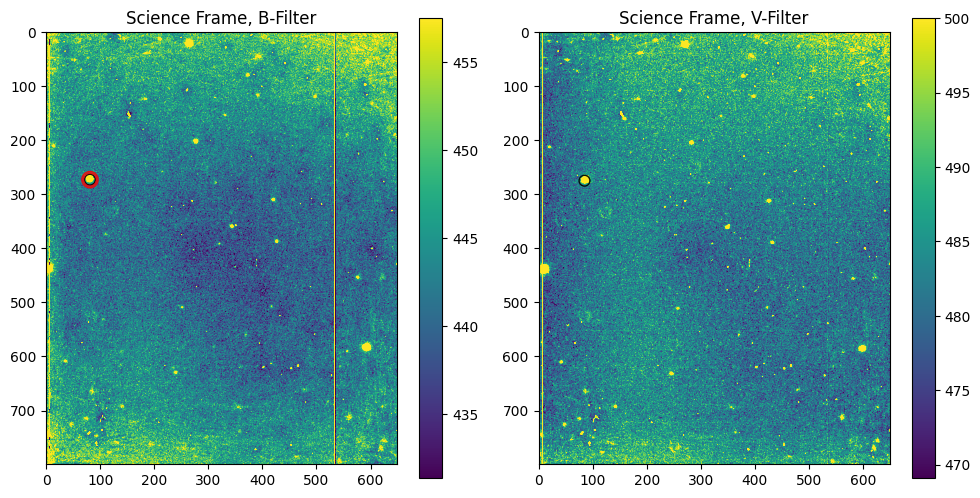

In [71]:
aperturesB = CircularAperture([80.689227, 272.671765], r=10)
loc_bkgB = CircularAnnulus([80.689227, 272.671765], r_in=12, r_out=15)
aperturesV = CircularAperture([84.575924, 274.590947], r=10)

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title("Science Frame, B-Filter")
im1 = ax[0].imshow(res_land_B, vmin=np.percentile(res_land_B, 3), vmax=np.percentile(res_land_B, 97))
plt.colorbar(im1)

ax[1].set_title("Science Frame, V-Filter")
im2 = ax[1].imshow(res_land_V, vmin=np.percentile(res_land_V, 3), vmax=np.percentile(res_land_V, 97))
plt.colorbar(im2)

aperturesB.plot(ax=ax[0], color='k', lw=1, alpha=0.9);
loc_bkgB.plot(ax=ax[0], color='r', lw=1, alpha=0.9);
aperturesV.plot(ax=ax[1], color='k', lw=1, alpha=0.9);
plt.tight_layout()

Find stars in NGC 6819 field using `DAOStarFinder`

In [106]:
# We trim the borders of each science frame to remove bad pixels at the edges
res_B = red_sci_ngc6819_B_v2 # sci_red['ngc6819_B'][100:700, 257:760] # [250:700, 300:750]
res_V = red_sci_ngc6819_V_v2 # sci_red['ngc6819_V'][100:700, 257:760]

# Astrometric alignment (registration) of both images
res_B_reg = astroalign.register(res_B,res_V,max_control_points=50)

In [116]:
_, median_B, std_B = sigma_clipped_stats(res_B_reg[0], sigma=5.0)   
#print(f"mean:{mean}, median:{median}, std:{std}") 
daofind = DAOStarFinder(fwhm=5, threshold=5.*std_B, exclude_border=True)  
sourcesB = daofind(res_B_reg[0] - median_B)  

In [117]:
sourcesB_df = sourcesB.to_pandas()
positionsB = sourcesB_df.filter(['xcentroid', 'ycentroid'])

In [118]:
sourcesB_df

id   xcentroid    ycentroid  sharpness  roundness1  roundness2  npix  \
0      1  289.505985     6.557271   0.293407   -0.013585   -0.476738    49   
1      2  138.046489    10.748086   0.992470   -0.248887   -0.186628    49   
2      3  512.817203    15.304410   0.388136   -0.207090   -0.462911    49   
3      4  888.889787    14.940435   0.909484    0.009816    0.042559    49   
4      5  899.423846    14.504259   0.416920   -0.211079   -0.659447    49   
..   ...         ...          ...        ...         ...         ...   ...   
548  549  638.117381  1010.563308   0.347347    0.201736   -0.534943    49   
549  550  904.976112  1011.073317   0.350311   -0.338796   -0.665175    49   
550  551  585.868997  1014.764259   0.284089   -0.298186   -0.517745    49   
551  552  564.064276  1016.910164   0.980784   -0.109655    0.495752    49   
552  553  380.723793  1019.641768   0.530882    0.061329   -0.668689    49   

     sky        peak       flux       mag  
0    0.0   54.970593   2.145155 -0.828647  
1    0.0   45.592878   1.191311 -0.190063  
2    0.0  709.418359  26.926542 -3.575451  
3    0.0   78.214744   2.259643 -0.885099  
4    0.0   67.622738   2.275715 -0.892795  
..   ...         ...        ...       ...  
548  0.0   64.985505   2.271697 -0.890876  
549  0.0   78.906584   2.983018 -1.186640  
550  0.0   75.951433   2.936310 -1.169505  
551  0.0   56.189671   1.408598 -0.371968  
552  0.0   35.838402   1.341631 -0.319082  

[553 rows x 11 columns]

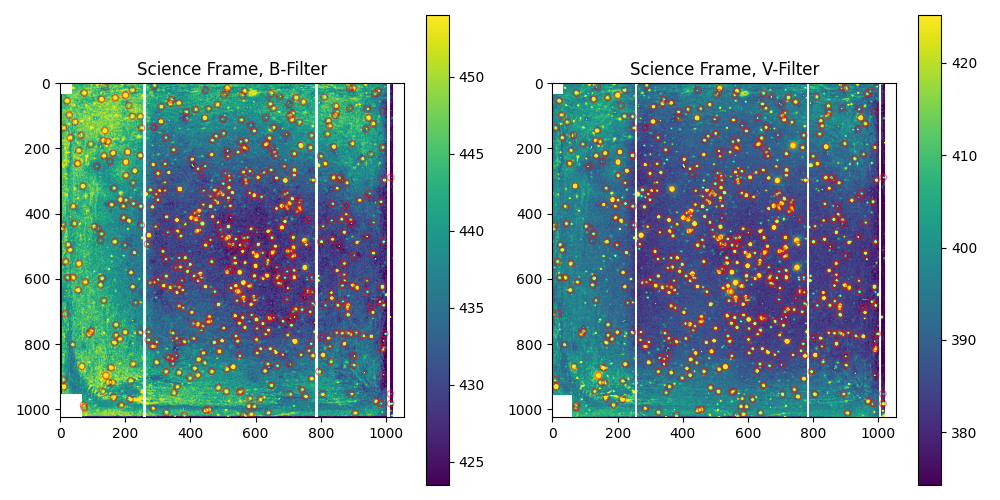

In [125]:
# positions = np.transpose((sources_df['xcentroid'], sources_df['ycentroid']))
aperturesB = CircularAperture(positionsB, r=10)
# aperturesV = CircularAperture(positionsV, r=6)

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].set_title("Science Frame, B-Filter")
im1 = ax[0].imshow(res_B_reg[0],vmin=np.nanpercentile(res_B_reg[0], 3), vmax=np.nanpercentile(res_B_reg[0], 97))
plt.colorbar(im1)

ax[1].set_title("Science Frame, V-Filter")
im2 = ax[1].imshow(res_V,vmin=np.nanpercentile(res_V, 3), vmax=np.nanpercentile(res_V, 97))
plt.colorbar(im2)

aperturesB.plot(ax=ax[0], color='red', lw=1, alpha=0.5);
aperturesB.plot(ax=ax[1], color='red', lw=1, alpha=0.5);
plt.tight_layout()

In [65]:
def aperture_photometry(data, x, y, r_star, r_in, r_out, verbose=False):
    """ Performs aperture photometry on point source 
    """
    # Determine local background and subtract it 
    locback = LocalBackground(r_in, r_out, bkg_estimator=MedianBackground())
    loc_bkg = locback(data,x,y)

    print(f"Local Background: {round(loc_bkg,3)}") if verbose else None

    # Create circular aperture
    aper = CircularAperture([x, y], r=r_star)
    res = aper.do_photometry(data-loc_bkg)
    return res

def star_magnitude(m_ref, F_1, F_ref):
    return -2.5*np.log10(F_1 / F_ref) + m_ref

In [121]:
# Landolt Field Star 111 1965 reference flux and magnitude

F_ref_B = aperture_photometry(res_land_B, 80.689227, 272.671765, 10, 15, 20, verbose=False)[0][0] # 2,4,6
F_ref_V = aperture_photometry(res_land_V, 84.575924, 274.590947, 10, 15, 20, verbose=False)[0][0]
m_ref_B = 1.710 + 11.419
m_ref_V = 11.419	
print("Landolt Flux B", F_ref_B)
print("Landolt Flux V", F_ref_V)

Landolt Flux B 27423.273979836158
Landolt Flux V 46384.621137933194


In [122]:
np.percentile(star_fluxes_B, 90)

8323.94215733316

In [123]:
star_fluxes_B = [aperture_photometry(res_B, x, y, 10, 15, 20, verbose=False)[0][0] for x,y in positionsB.values]
mag_B = (star_fluxes_B - F_ref_B) + m_ref_B

star_fluxes_V = [aperture_photometry(res_V, x, y, 10, 15, 20, verbose=False)[0][0] for x,y in positionsB.values]
mag_V = (star_fluxes_V - F_ref_V) + m_ref_V

star_mags_B = np.array([star_magnitude(m_ref_B, F, F_ref_B) for F in star_fluxes_B])
star_fluxes_V = [aperture_photometry(res_V, x, y, 10, 12, 15, verbose=False)[0][0] for x,y in positionsB.values]
star_mags_V = np.array([star_magnitude(m_ref_V, F, F_ref_V) for F in star_fluxes_V])

C:\Users\avipa\AppData\Local\Temp\ipykernel_25552\2582654717.py:16: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(F_1 / F_ref) + m_ref
C:\Users\avipa\AppData\Local\Temp\ipykernel_25552\2582654717.py:16: RuntimeWarning: invalid value encountered in log10
  return -2.5*np.log10(F_1 / F_ref) + m_ref


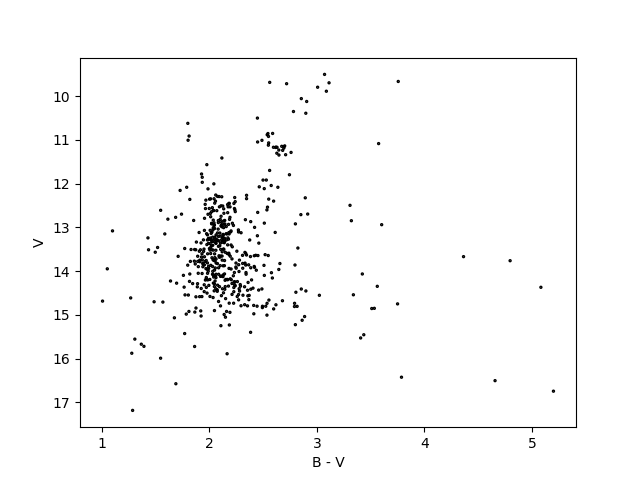

In [126]:
plt.figure()
plt.scatter(star_mags_B - star_mags_V, star_mags_V, s=2, c='None', edgecolors='k')
plt.xlabel("B - V")
plt.ylabel("V")
plt.gca().invert_yaxis()